## Imports

In [24]:
#import the Forward Modelling Engine modules - LoopStructural
from LoopStructural import GeologicalModel
from LoopStructural.datasets import load_noddy_single_fold
from LoopStructural.visualisation.model_visualisation import LavaVuModelViewer
from LoopStructural.utils.helper import strike_dip_vector, plunge_and_plunge_dir_to_vector
# from LoopStructural.visualisation.rotation_angle_plotter import RotationAnglePlotter
# import other libraries
import pandas as pd
import numpy as np
# from scipy.interpolate import Rbf
# import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.DEBUG)
%load_ext snakeviz

In [2]:
# load the sample data
data, boundary_points = load_noddy_single_fold()
data.head()

,X,Y,Z,dip,strike,type,coord,random
972,500.0,500.0,5500.0,69.965373,399.166448,s0,NaN,0.126657
976,500.0,500.0,6000.0,69.965373,399.166448,s0,NaN,0.376144
980,500.0,500.0,6500.0,69.965373,399.166448,s0,NaN,0.731684
984,500.0,500.0,7000.0,69.965373,399.166448,s0,NaN,0.479522
988,500.0,500.0,7500.0,69.965373,399.166448,s0,NaN,0.465607


The input dataset was generated using Noddy by sampling the orientation of a structure on a regular grid. We have loaded it into a pandas DataFrame, this is basically an excel spreadsheet for python.
Above are the first 5 rows of the dataset and as we can see it is regularly sampled with data points being sampled regularly along the $z$, $y$ and $x$ axes. In order to avoid artefacts due to the sampling errors we will shuffle the data. We can do this using the `random` column in the DataFrame (ensuring everyone has the same data).

In [3]:
data = data.sort_values('random') # sort the data by a random int then we can select N random points 
data.head()

,X,Y,Z,dip,strike,type,coord,random
11272,2000.0,6000.0,6000.0,70.370847,398.150099,s0,NaN,0.000340
1120,2000.0,500.0,7500.0,70.370847,398.150099,s0,NaN,0.003175
11356,3000.0,6000.0,5500.0,64.030744,417.522113,s0,NaN,0.004159
7724,3500.0,4000.0,8000.0,64.030744,417.522113,s0,NaN,0.004213
5608,500.0,3000.0,7500.0,69.965373,399.166448,s0,NaN,0.005269


The data can be visualised using the lavavu 3d viewer - by first converting from strike and dip to normal vectors. Note that there are a lot of data points to display as the model volume was regularly sampled on a grid.

In [4]:
npoints = 20

### Build model using maximum likelihood


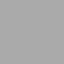

aaaa


In [5]:
# val = /
mdata = pd.concat([data[:npoints],data[data['type']=='s1']])
model = GeologicalModel(boundary_points[0,:],boundary_points[1,:])
model.set_model_data(mdata)
fold_frame = model.create_and_add_fold_frame('s1',
                                             interpolatortype='PLI',
                                             nelements=10000,buffer=0.5,
                                             solver='pyamg',
                                            damp=True
                                            )
stratigraphy = model.create_and_add_folded_foliation('s0',
                                               fold_frame['feature'],
                                                nelements=10000,
                                               fold_axis=[-6.51626577e-06, -5.00013645e-01, -8.66017526e-01],
#                                                    limb_wl=1
                                                     buffer=0.5
                                                    )
viewer = LavaVuModelViewer(model,background="white")
# viewer.add_scalar_field(model.bounding_box,(38,55,30),
#                       'box',
#                      paint_with=stratigraphy,
#                      cmap='prism')
viewer.add_isosurface(fold_frame['feature'][0],
                      colour='blue',
#                       isovalue=0.4,
                      alpha=0.5)
viewer.add_data(fold_frame['feature'][0])
viewer.add_isosurface(fold_frame['feature'][1],colour='green',alpha=0.5,isovalue=0)
# viewer.add_vector_field(fold_frame['feature'][0],locations=fold_frame['feature'][0].get_interpolator().support.barycentre())
viewer.add_data(fold_frame['feature'][1])

# viewer.add_data(stratigraphy['feature'])
viewer.add_isosurface(stratigraphy['feature'])
viewer.interactive()
logging.getLogger().critical("aaaa")
# plt.plot(stratigraphy['foliation'],stratigraphy['limb_rotation'],'bo')
# x = np.linspace(fold_frame['feature'][0].min(),fold_frame['feature'][1].max(),100)
# plt.plot(x,stratigraphy['fold'].fold_limb_rotation(x),'r--')

### Useful pdfs

In [26]:
def normal(value,mu, sigma):
    prob = -np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(value-mu)**2/sigma**2
#     print(prob)
    return prob#-np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(value-mu)**2/sigma**2

def jefferyprior(sigma):
    if sigma <= 0:
        return -np.inf
    return np.log(sigma)

### Define the fixed parts of the model

In [27]:
from LoopStructural.modelling.fold import fourier_series
model = GeologicalModel(boundary_points[0,:],boundary_points[1,:])
model.set_model_data(mdata)
fold_frame = model.create_and_add_fold_frame('s1',
                                             interpolatortype='PLI',
                                             nelements=10000,buffer=0.5,
                                             solver='lu',
                                            damp=True
                                            )

### Define log_likelihood
We can move the expensive parts of the computation out of the likelihood function to reduce computational time

In [106]:
wl = 10
c0 = 0
c1 = 0
c2 = 0 
fold_limb_function = lambda x: np.rad2deg(
            np.arctan(
                fourier_series(x, c0, c1, c2, wl)))

strati = model.create_and_add_folded_foliation('s0',
                                           fold_frame['feature'],
                                            nelements=10000,
                                           fold_axis=[-6.51626577e-06, -5.00013645e-01, -8.66017526e-01],
#                                                    limb_wl=1
                                                 buffer=0.5,
                                               limb_function=fold_limb_function,
                                               solver = 'fake'
                                        )
def log_likelihood(theta):
    # unpack parameters
    wl, c0, c1, c2, sigma = theta
    fold_limb_function = lambda x: np.rad2deg(
            np.arctan(
                fourier_series(x, c0, c1, c2, wl)))
    strati['fold'].fold_limb_rotation.set_function(fold_limb_function)
#     sigma = .1

    misfit = strati['fold'].fold_limb_rotation.calculate_misfit()
    
    log_like = -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (0 - misfit) ** 2 / sigma ** 2)

    if ~np.isfinite(log_like):
        return -np.inf
    
    return log_like

INFO:LoopStructural.modelling.core.geological_model:Creating regular tetrahedron mesh with 21280 elements 
for modelling using DFI
INFO:LoopStructural.modelling.features.geological_feature_builder:Adding 0 faults to s0
INFO:LoopStructural.modelling.fold.foldframe:Not using fold axis for fold limb rotation angle calculation
INFO:LoopStructural.modelling.features.geological_feature_builder:Adding fold to s0
INFO:LoopStructural.modelling.fold.fold:Using constant fold axis
INFO:LoopStructural.interpolators.discrete_fold_interpolator:Adding fold orientation constraint to s0 w = 10.000000
INFO:LoopStructural.interpolators.discrete_fold_interpolator:Adding fold axis constraint to s0 w = 10.000000
INFO:LoopStructural.interpolators.discrete_fold_interpolator:Adding fold normalisation constraint to s0 w = 1.000000
INFO:LoopStructural.interpolators.discrete_fold_interpolator:Adding fold regularisation constraint to s0 w = 0.100000
INFO:LoopStructural.interpolators.piecewiselinear_interpolator:Set

### Define prior
Assign each of the model parameters to a PDF using the helper functions before. 

In [153]:
def log_prior(theta):
    wl, c0, c1, c2, sigma = theta
    lp = jefferyprior(sigma)
    lp+= normal(c0,0,2)
    lp+= normal(c1,0,2)
    lp+= normal(c2,0,2)
    lp+= normal(wl,10,3)
    return lp

In [154]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta)
    return lp + log_likelihood(theta)

In [155]:
from scipy.optimize import minimize
nll = lambda *args : -log_likelihood(*args)
initial = [10,1,1,1,0.0001]
soln = minimize(nll, initial)
print(soln)

      fun: -22.189727949947354
 hess_inv: array([[ 3.51281300e-02,  5.52752749e-05, -4.64452481e-05,
         4.27726681e-05,  1.24980065e-04],
       [ 5.52752749e-05,  1.90405915e-07, -7.78299849e-08,
         1.39645540e-07,  4.35825041e-07],
       [-4.64452481e-05, -7.78299849e-08,  2.43594454e-07,
         8.70537799e-09, -4.09711442e-07],
       [ 4.27726681e-05,  1.39645540e-07,  8.70537799e-09,
         2.92195689e-07,  2.62955151e-07],
       [ 1.24980065e-04,  4.35825041e-07, -4.09711442e-07,
         2.62955151e-07,  1.44597388e-04]])
      jac: array([-0.00012755,  0.03898406, -0.02278686,  0.05171728,  0.00075936])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1068
      nit: 94
     njev: 151
   status: 2
  success: False
        x: array([ 1.10609776e+01,  8.09251587e-04, -1.11190413e-03, -1.98493379e-02,
        7.97847011e-02])


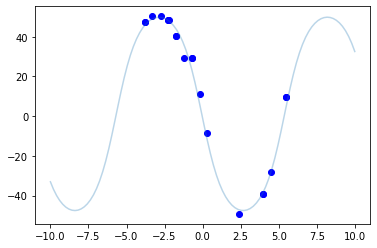

In [156]:
x = np.linspace(-10,10,100)
plt.plot(stratigraphy['fold'].fold_limb_rotation.fold_frame_coordinate,stratigraphy['fold'].fold_limb_rotation.rotation_angle,'bo')
wl, c0, c1, c2, sig = soln['x']
plt.plot(x,np.rad2deg(
            np.arctan(
                fourier_series(x, c0, c1, c2, wl))),alpha=0.3)

In [157]:
import emcee
# ndim = 5
start = soln.x#stratigraphy['fold'].fold_limb_rotation.fitted_params#np.zeros(ndim)#np.array([600,0,0,0])
pos = soln.x + 1e-3 * np.random.randn(10, ndim)
nwalkers, ndim = pos.shape

In [164]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 200, progress=True)

100%|██████████| 200/200 [00:00<00:00, 393.64it/s]


State([[ 1.12679656e+01  1.00881135e-03 -1.04132884e-03 -1.96792569e-02
   8.99767996e-02]
 [ 1.10024688e+01  8.68672826e-04 -1.18754818e-03 -2.04812015e-02
   7.47584094e-02]
 [ 1.14844440e+01  1.59734366e-03 -2.60253809e-03 -1.98459980e-02
   9.65690098e-02]
 [ 1.13235223e+01  1.05071885e-03 -1.55702815e-03 -1.97269327e-02
   8.07223017e-02]
 [ 1.13068369e+01  1.25029539e-03 -2.89673398e-03 -1.95389485e-02
   7.71346927e-02]
 [ 1.08227436e+01 -2.48211400e-04 -7.62642696e-04 -1.96416344e-02
   1.30553413e-01]
 [ 1.12075179e+01  1.37083453e-04 -1.17656506e-03 -2.05338433e-02
   1.17888584e-01]
 [ 1.11174203e+01  8.17541034e-04 -1.81771463e-03 -1.99631591e-02
   1.01766944e-01]
 [ 1.07234376e+01  8.56675703e-04  1.46643636e-04 -1.98014130e-02
   1.11677567e-01]
 [ 1.15105577e+01  1.13257084e-03 -7.92351235e-04 -1.90051596e-02
   1.51191953e-01]], log_prob=[25.60389092 24.87614885 22.97629517 25.42451868 19.82531722 21.53105708
 22.58012328 25.09017911 22.61760721 20.13074302], blobs=Non

In [165]:
flat_samples = sampler.get_chain(discard=100, flat=True)#,thin=10)

(array([ 16.,  39., 167., 220., 216., 181., 116.,  32.,   9.,   4.]),
 array([10.44812216, 10.61614144, 10.78416072, 10.95218   , 11.12019928,
        11.28821856, 11.45623784, 11.62425713, 11.79227641, 11.96029569,
        12.12831497]),
 <a list of 10 Patch objects>)

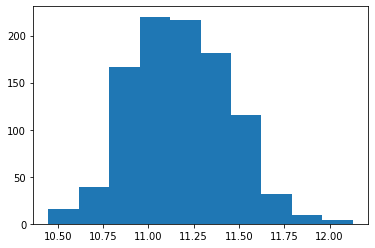

In [166]:
plt.hist(flat_samples[:,0])

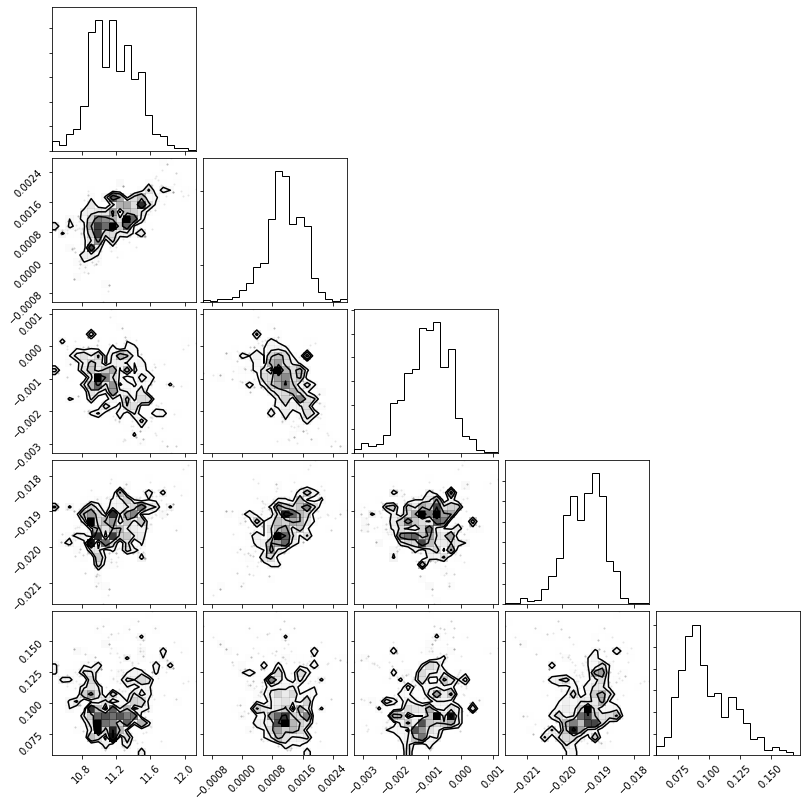

In [167]:
import corner
flat_samples.shape
fig = corner.corner(
    flat_samples
);

In [168]:
import matplotlib.pyplot as plt

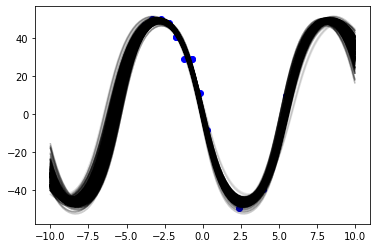

In [169]:
x = np.linspace(-10,10,100)
plt.plot(stratigraphy['fold'].fold_limb_rotation.fold_frame_coordinate,stratigraphy['fold'].fold_limb_rotation.rotation_angle,'bo')
for i in range(len(flat_samples)):
    wl, c0, c1, c2, sig = flat_samples[i,:]
    plt.plot(x,np.rad2deg(
                np.arctan(
                    fourier_series(x, c0, c1, c2, wl))),alpha=0.1,color='black')
    

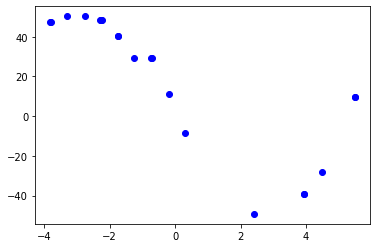

In [125]:
plt.plot(stratigraphy['fold'].fold_limb_rotation.fold_frame_coordinate,stratigraphy['fold'].fold_limb_rotation.rotation_angle,'bo')